# 3. word2vec

In [1]:
import numpy as np

## 3.1.2 추론기반기법개요

In [2]:
# 단어를 원핫 인코딩으로 표현한 후 
# 완전연결계층에 의한 변환

c = np.array([1,0,0,0,0,0,0])  # 입력
W = np.random.randn(7, 3)      # 가중치
h = np.matmul(c, W)            # 중간 노드
print(h)

[ 2.21407743 -0.04152525 -0.55556136]


In [3]:
import sys 
sys.path.append('..')
from common.layers import MatMul

c = np.array([1,0,0,0,0,0,0])  # 입력
W = np.random.randn(7, 3)      # 가중치
layer = MatMul(W)              # 중간 노드
h = layer.forward(c)
print(h)

[ 0.97741675 -1.00518531  1.38179853]


## 3.2.1 CBOW모델의 추론처리

In [4]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

# 맥락 샘플
c0 = np.array([[1,0,0,0,0,0,0]])
c1 = np.array([[0,0,1,0,0,0,0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)


[[-0.26625503  0.85614297 -0.1412434  -2.00220927 -1.54855732  0.7161108
   0.2710773 ]]


## 3.3.1 맥락과 타깃

### 정한 단어는 타깃이 되어 정답레이블이 되고 그 단어의 주변단어들은 맥락이되어 입력데이터가 된다.

In [5]:
# 맥락과 타깃을 만드는 함수
import sys
sys.path.append('..')
from common.util import preprocess

text = 'You say goodby and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodby', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [6]:
# 맥락과 타깃을 만드는 함수
def create_contexts_target(corpus, window_size = 1) :
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus) - window_size) :
        cs = []
        for t in range(-window_size, window_size + 1) :
            if (t == 0) :
                continue
            cs.append(corpus[idx+t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

In [7]:
# 맥락과 타깃을 뽑아내는 코드
contexts, target = create_contexts_target(corpus, window_size=1)
print("contexts")
print(contexts)
print("target")
print(target)

contexts
[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
target
[1 2 3 4 1 5]


## 3.3.2 원핫 표현으로 변환

In [8]:
# 내가 만든거
def convert_one_hot(corpus, vocab_size):
    # 1차원또는 2차원 corpus를 가져온다.
    N = corpus.shape[0]

    if corpus.ndim == 1 :
        output = np.zeros((N,vocab_size), dtype = np.int32)
        for i in range(N) :
            output[i,corpus[i]] = 1

    elif corpus.ndim == 2 :
        num = corpus.shape[1]
        output = np.zeros((N, num, vocab_size), dtype = np.int32)
        for i in range(N) :
            for j in range(num) :
                output[i,j,corpus[j]] = 1
    return output    

In [9]:
# 책의 것
def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환

    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1
                
    return one_hot

In [10]:
# 원핫 표현으로 변환 해보기


text = 'You say goodby and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts =convert_one_hot(contexts, vocab_size)

print("target")
print(target)
print("contexts")
print(contexts)

target
[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
contexts
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


# 3.4 CBOW 구현

In [11]:
import sys
sys.path.append('..')
from common.layers import MatMul, SoftmaxWithLoss

In [12]:
# CBOW의 간단한 구현
class SimpleCBOW :
    def __init__(self, vocab_size, hidden_size) :
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers :
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다. 
        self.word_vecs = W_in
            

    def forward(self, contexts, target) :
        h0 = self.in_layer0.forward(contexts[:,0])
        h1 = self.in_layer1.forward(contexts[:,1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout = 1) :
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

## 3.4.1 학습 코드 구현

In [13]:
import sys 
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

C:\Users\User\anaconda3\envs\DIVA\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\envs\DIVA\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\envs\DIVA\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\envs\DIVA\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


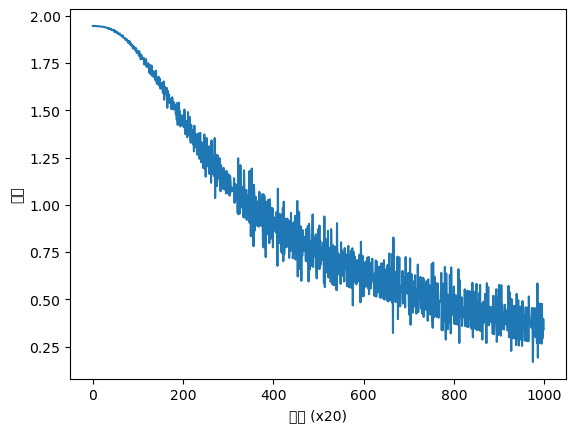

In [14]:
window_size = 1 
hidden_size = 3
batch_size = 3
max_epoch = 1000

# 전처리 하는 중
text = 'You say goodby and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts =convert_one_hot(contexts, vocab_size)


model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [15]:
# 분산표현 확인하기

word_vecs = model.word_vecs
for word_id, word in id_to_word.items() :
    print(word, word_vecs[word_id])

you [-1.0731049  1.081911  -1.673838 ]
say [ 1.4802505  -1.4683597  -0.38662252]
goodby [-1.3774444   1.3890147   0.30593506]
and [ 1.0827204 -1.0868244 -1.7645113]
i [-1.3465021   1.3713853   0.31014878]
hello [-1.066029   1.1044236 -1.6844603]
. [ 1.3923529 -1.4157674  1.677834 ]


## 3.5.2 skip-gram 모델

In [16]:
class SimpleSkipGram :
    def __init__(self, vocab_size, hidden_size) :
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        #계층 생성
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers :
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target) :
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:,0])
        l2 = self.loss_layer2.forward(s, contexts[:,1])
        loss = l1 + l2
        
    def backward(self, dout=1) :
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None


| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

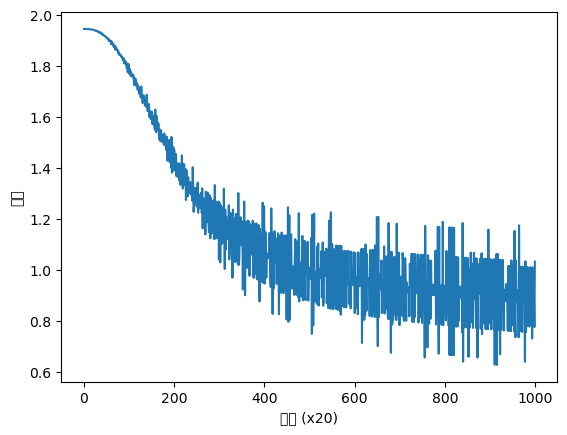

In [17]:
window_size = 1 
hidden_size = 3
batch_size = 3
max_epoch = 1000

# 전처리 하는 중
text = 'You say goodby and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts =convert_one_hot(contexts, vocab_size)


model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()